In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [91]:
train_data = pd.read_csv("train.csv")

In [92]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

**Imputing missing values**
From EDA notebook, missing data is imputed as follows:
- For LotFrontage and MasVnrArea, impute by median of column
- For MasVnrType and Electrical, impute with mode of the column
- For all other categorical columns with missing data, impute with a "NA" label
- Drop the GrgYrBuilt column 

In [93]:
train_data["LotFrontage"] = train_data["LotFrontage"].fillna(train_data["LotFrontage"].median())
train_data["MasVnrArea"] = train_data["MasVnrArea"].fillna(train_data["MasVnrArea"].median())

train_data["MasVnrType"] = train_data["MasVnrType"].fillna(train_data["MasVnrType"].mode())
train_data["Electrical"] = train_data["Electrical"].fillna(train_data["Electrical"].mode())

cat_cols= [x for x in train_data.columns if train_data[x].dtype==np.object]
train_data[cat_cols]=train_data[cat_cols].fillna("NA")
train_data.drop("GarageYrBlt", axis=1, inplace=True)

In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non

**Applying features' transformations**
- Transform target to log10 (not necessarily needed)
- MoSold and MSSubClass turned from int to str

In [95]:
train_data["LogSalePrice"]=np.log(train_data["SalePrice"])

train_data[["MoSold", "MSSubClass"]] = train_data[["MoSold", "MSSubClass"]].astype(str)

In [96]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null object
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 no

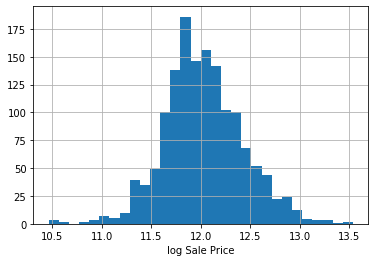

In [97]:
train_data["LogSalePrice"].hist(bins=30)
plt.xlabel("log Sale Price")
plt.show()

In [98]:
# cardinality of each categorical feature 

for column in cat_cols:
    print('Number of categories in the variable {}: {}'.format(column,len(train_data[column].unique())))


Number of categories in the variable MSZoning: 5
Number of categories in the variable Street: 2
Number of categories in the variable Alley: 3
Number of categories in the variable LotShape: 4
Number of categories in the variable LandContour: 4
Number of categories in the variable Utilities: 2
Number of categories in the variable LotConfig: 5
Number of categories in the variable LandSlope: 3
Number of categories in the variable Neighborhood: 25
Number of categories in the variable Condition1: 9
Number of categories in the variable Condition2: 8
Number of categories in the variable BldgType: 5
Number of categories in the variable HouseStyle: 8
Number of categories in the variable RoofStyle: 6
Number of categories in the variable RoofMatl: 8
Number of categories in the variable Exterior1st: 15
Number of categories in the variable Exterior2nd: 16
Number of categories in the variable MasVnrType: 5
Number of categories in the variable ExterQual: 4
Number of categories in the variable ExterCon

**Encoding categorical variables**

For the baseline models, hot one encode all cat vars

In [99]:
ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    drop_last=False) # automatically detects all cat vars in data

ohe_enc.fit(train_data)

train_data = ohe_enc.transform(train_data)

In [100]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 331 entries, Id to SaleCondition_Family
dtypes: float64(3), int64(328)
memory usage: 3.7 MB


In [101]:
train_data.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,LogSalePrice,MSSubClass_60,MSSubClass_20,MSSubClass_70,MSSubClass_50,MSSubClass_190,MSSubClass_45,MSSubClass_90,MSSubClass_120,MSSubClass_30,MSSubClass_85,MSSubClass_80,MSSubClass_160,MSSubClass_75,MSSubClass_180,MSSubClass_40,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,Street_Pave,Street_Grvl,Alley_NA,Alley_Grvl,Alley_Pave,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,Condition2_Norm,Condition2_Artery,Condition2_RRNn,Condition2_Feedr,Condition2_PosN,Condition2_PosA,Condition2_RRAn,Condition2_RRAe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_WdShngl,RoofMatl_Metal,RoofMatl_WdShake,RoofMatl_Membran,RoofMatl_Tar&Grv,RoofMatl_Roll,RoofMatl_ClyTile,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,MasVnrType_NA,ExterQual_Gd,ExterQual_TA,ExterQual_Ex,ExterQual_Fa,ExterCond_TA,ExterCond_Gd,ExterCond_Fa,ExterCond_Po,ExterCond_Ex,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Ex,BsmtQual_NA,BsmtQual_Fa,BsmtCond_TA,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Fa,BsmtCond_Po,BsmtExposure_No,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_Av,BsmtExposure_NA,BsmtFinType1_GLQ,BsmtFinType1_ALQ,BsmtFinType1_Unf,BsmtFinType1_Rec,BsmtFinType1_BLQ,BsmtFinType1_NA,BsmtFinType1_LwQ,BsmtFinType2_Unf,BsmtFinType2_BLQ,BsmtFinType2_NA,BsmtFinType2_ALQ,BsmtFinType2_Rec,BsmtFinType2_LwQ,BsmtFinType2_GLQ,Heating_GasA,Heating_GasW,Heating_Grav,Heating_Wall,Heating_OthW,Heating_Floor,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_TA,HeatingQC_Fa,HeatingQC_Po,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseF,Electrical_FuseA,Electrical_FuseP,Electrical_Mix,Electrical_NA,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa,Functional_Typ,Functional_Min1,Functional_Maj1,Functional_Min2,Functional_Mod,Functional_

In [102]:
X = train_data.drop(["Id", "SalePrice", "LogSalePrice"], axis=1)
y = train_data["SalePrice"]

**Dummy mean baseline**

In [103]:
dummy_regr = DummyRegressor(strategy="mean")
scores = cross_val_score(dummy_regr, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: 0.41 (+/- 0.03)


In [104]:
scores

array([0.39284391, 0.43183241, 0.41451226, 0.40140847, 0.39754578])

In [105]:
dummy_regr.fit(X, y)

predictions = dummy_regr.predict(X)

In [106]:
predictions

array([180921.19589041, 180921.19589041, 180921.19589041, ...,
       180921.19589041, 180921.19589041, 180921.19589041])

In [107]:
score = np.sqrt(mean_squared_log_error(y, predictions))

score

0.4075977724850718

**Random Forest Regressor Baseline**

In [108]:
rf_regr = RandomForestRegressor()
scores = cross_val_score(rf_regr, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: 0.15 (+/- 0.01)


In [109]:
lightgbm_regr = LGBMRegressor()
scores = cross_val_score(lightgbm_regr, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: 0.14 (+/- 0.02)


In [115]:
# since there is colinearlity in features (see EDA notenook), it is possible that regularization would improve performance

lightgbm_regr2 = LGBMRegressor(lambda_l1=1.0)
scores = cross_val_score(lightgbm_regr2, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: 0.13 (+/- 0.02)


In [119]:
lightgbm_regr3 = LGBMRegressor(lambda_l2=10.0)
scores = cross_val_score(lightgbm_regr3, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: 0.13 (+/- 0.02)
